# Autoregressive Model Testing

In [406]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [407]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Checking Model Assumtion: Series is Stationary 

In [408]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("=> Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary.")
    else:
        print("=> Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")

In [409]:
macro = 'GDP'
adf_test(df[macro], title=macro)
adf_test(df['Bitcoin'], title='Bitcoin') 
df_tempt = df[[macro, 'Bitcoin']].dropna().copy()
df_tempt = df_tempt.dropna()  # Drop NaN from lag 
df[macro + '_diff'] = df[macro].diff()
adf_test(df[macro + '_diff'].dropna(), title=macro + " Differenced")
macro = macro + '_diff' 

Augmented Dickey-Fuller Test: GDP
ADF Statistic: -1.1789834271972168
p-value: 0.6825705492402228
# Lags Used: 0
Number of Observations Used: 88
=> Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.
Augmented Dickey-Fuller Test: Bitcoin
ADF Statistic: -6.081040541682986
p-value: 1.092051938374884e-07
# Lags Used: 0
Number of Observations Used: 88
=> Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary.
Augmented Dickey-Fuller Test: GDP Differenced
ADF Statistic: -6.677641554513602
p-value: 4.423591925033012e-09
# Lags Used: 2
Number of Observations Used: 85
=> Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary.


In [410]:
df_tempt = df[[macro, 'Bitcoin']].dropna().copy()
df_tempt = df_tempt.dropna()  # Drop NaN from lag
df[macro + '_diff'] = df[macro].diff()
adf_test(df[macro + '_diff'].dropna(), title=macro + " Differenced")
macro = macro + '_diff'


Augmented Dickey-Fuller Test: GDP_diff Differenced
ADF Statistic: -5.998692219572659
p-value: 1.6774700272565168e-07
# Lags Used: 6
Number of Observations Used: 80
=> Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97263D+00    |proj g|=  7.40386D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   7.404D-06   7.973D+00
  F =   7.9726342989121965     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

 This problem is unconstrained.
 This problem is unconstrained.


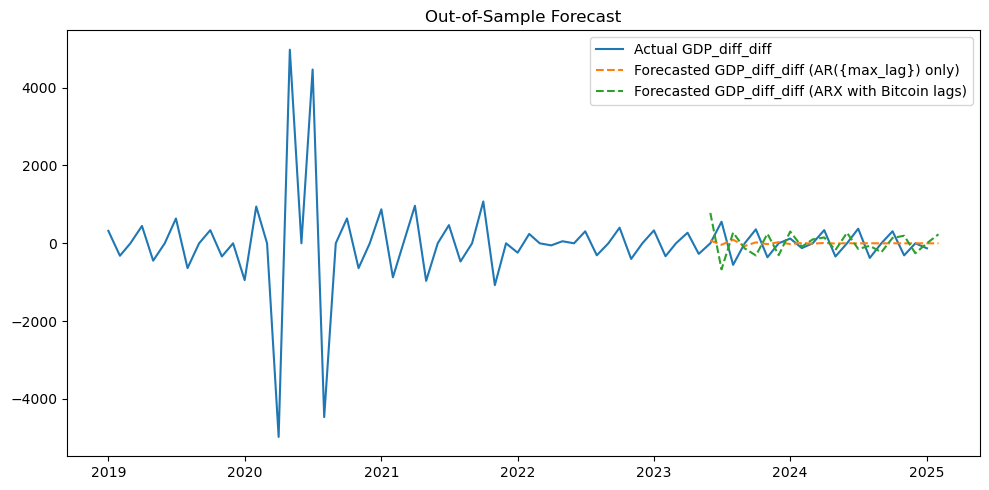

In [411]:
max_lag = 3

# Create lagged Bitcoin volatility columns

for lag in range(1, max_lag + 1):
    df[f'Bitcoin_vol_lag{lag}'] = df['Bitcoin'].shift(lag)

# Drop NaNs created by lagging
df = df.dropna().copy()

# Separate endogenous and exogenous variables
endog = df[macro]
exog = df[[f'Bitcoin_vol_lag{lag}' for lag in range(1, max_lag + 1)]]

# Train/test split
train_end = '2023-05-01'
train_endog = endog[:train_end]
train_exog = exog[:train_end]

test_endog = endog[train_end:]
test_exog = exog[train_end:]


# 1. AR model (GDP only), with AR order = max_lag
model_macro = SARIMAX(train_endog,
                    order=(max_lag, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
result_macro = model_macro.fit()

# 2. ARX model (GDP + lagged Bitcoin volatility)
model_withCryp = SARIMAX(train_endog,
                         exog=train_exog,
                         order=(max_lag, 0, 0),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_withCryp = model_withCryp.fit()
print("=== AR Model Summary ===")
print(result_macro.summary())

print("\n=== ARX Model Summary ===")
print(results_withCryp.summary())

# Forecast
forecast_1 = result_macro.get_forecast(steps=len(test_endog))
forecast_2 = results_withCryp.get_forecast(steps=len(test_endog), exog=test_exog)

predicted_mean1 = forecast_1.predicted_mean
predicted_mean2 = forecast_2.predicted_mean

mae_ar = mean_absolute_error(test_endog, predicted_mean1)
rmse_ar = np.sqrt(mean_squared_error(test_endog, predicted_mean1))
r2_ar = r2_score(test_endog, predicted_mean1)

# Calculate forecast errors for ARX model
mae_arx = mean_absolute_error(test_endog, predicted_mean2)
rmse_arx = np.sqrt(mean_squared_error(test_endog, predicted_mean2))
r2_arx = r2_score(test_endog, predicted_mean2)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(endog, label='Actual ' + macro)
plt.plot(predicted_mean1, label=f'Forecasted ' + macro+ ' (AR({max_lag}) only)', linestyle='--')
plt.plot(predicted_mean2, label=f'Forecasted ' + macro+ ' (ARX with Bitcoin lags)', linestyle='--')
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()

In [412]:
mae_ar = mean_absolute_error(test_endog, predicted_mean1)
rmse_ar = np.sqrt(mean_squared_error(test_endog, predicted_mean1))
r2_ar = r2_score(test_endog, predicted_mean1)
mape1 = mean_absolute_percentage_error(test_endog, predicted_mean1)
mape1 = np.mean(np.abs((test_endog - predicted_mean1) / test_endog.replace(0, np.nan)))


# Calculate forecast errors for ARX model
mae_arx = mean_absolute_error(test_endog, predicted_mean2)
rmse_arx = np.sqrt(mean_squared_error(test_endog, predicted_mean2))
r2_arx = r2_score(test_endog, predicted_mean2)
mape2 = mean_absolute_percentage_error(test_endog, predicted_mean2)
mape2 = np.mean(np.abs((test_endog - predicted_mean2) / test_endog.replace(0, np.nan)))


# Print metrics
print("AR model test set evaluation:")
print(f"  MAE:  {mae_ar:.4f}")
print(f"  RMSE: {rmse_ar:.4f}")
print(f"  R²:   {r2_ar:.4f}\n")
print("Mean Absolute Percentage Error (MAPE) of the forecast:", mape1)

print("ARX model test set evaluation:")
print(f"  MAE:  {mae_arx:.4f}")
print(f"  RMSE: {rmse_arx:.4f}")
print(f"  R²:   {r2_arx:.4f}")
print("Mean Absolute Percentage Error (MAPE) of the forecast:", mape2)

AR model test set evaluation:
  MAE:  217.5128
  RMSE: 277.2590
  R²:   0.0444

Mean Absolute Percentage Error (MAPE) of the forecast: 1.0232615135647034
ARX model test set evaluation:
  MAE:  300.7733
  RMSE: 388.6365
  R²:   -0.8775
Mean Absolute Percentage Error (MAPE) of the forecast: 1.1912233374157342


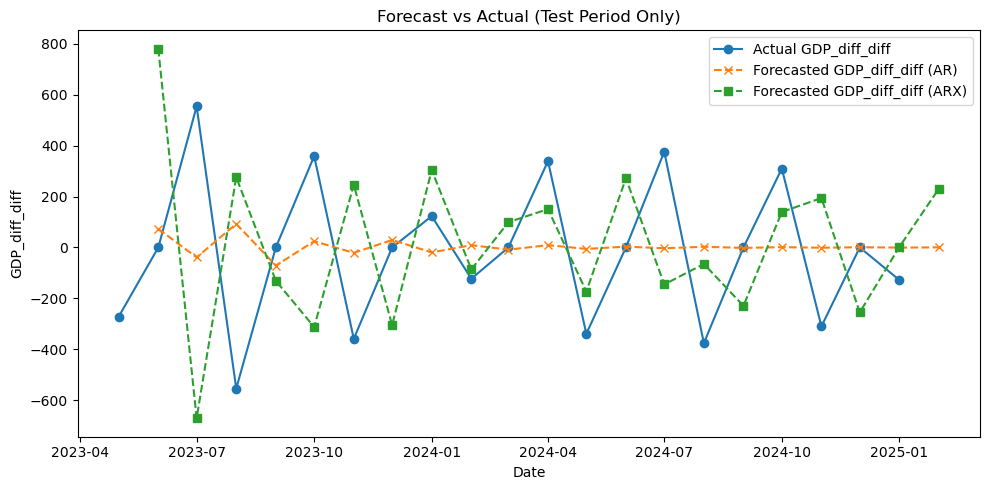

In [413]:
# Plot only test data with forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_endog, label='Actual ' + macro, marker='o')
plt.plot(predicted_mean1, label=f'Forecasted {macro} (AR)', linestyle='--', marker='x')
plt.plot(predicted_mean2, label=f'Forecasted {macro} (ARX)', linestyle='--', marker='s')
plt.title("Forecast vs Actual (Test Period Only)")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()


# Seasonal ARIMA Testing 

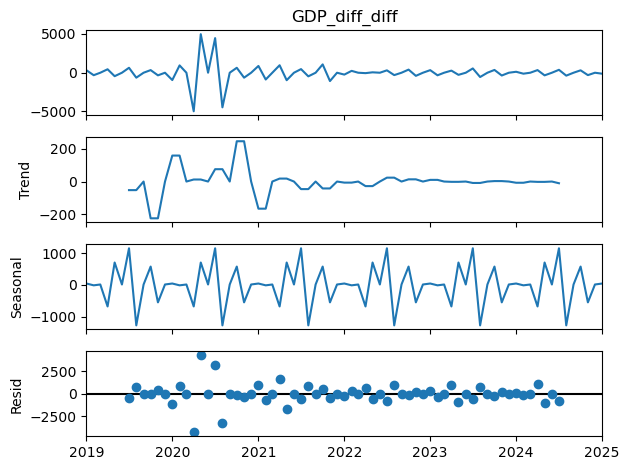

In [414]:
result = seasonal_decompose(df[macro], model='additive', period=12)  # Assuming monthly data
result.plot()
plt.show()

In [415]:
# Seasonal period, e.g. 12 for monthly data
s = 12  

p = d = q = range(0, 2)  # try 0 or 1 for each
seasonal_pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_order = None
best_seasonal_order = None

for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[macro],
                                            order=param,
                                            seasonal_order=(seasonal_param[0], seasonal_param[1], seasonal_param[2], s),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f'Best SARIMA{best_order}x{best_seasonal_order}{s} - AIC:{best_aic}')


/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Best SARIMA(0, 0, 1)x(0, 1, 1)12 - AIC:746.2848947927379


In [416]:
(p, d, q) = (1, 0, 1)
(P, D, Q, s) = (0, 1, 1, 12)

model = SARIMAX(train_endog,
                exog=train_exog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),  # s = 12 for monthly data
                enforce_stationarity=False,
                enforce_invertibility=False)
result = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06798D+01    |proj g|=  2.94022D-04
  ys=-1.290E+01  -gs= 4.908E-01 BFGS update SKIPPED


 This problem is unconstrained.


  ys=-1.716E+01  -gs= 4.951E-01 BFGS update SKIPPED

At iterate    5    f=  9.50685D+00    |proj g|=  1.48177D+05
  ys=-3.196E+01  -gs= 4.993E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6    101      3     3     0   1.482D+05   9.507D+00
  F =   9.5068481518451176     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
